In [24]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss, GaussianNLLLoss
from torch.optim import LBFGS, ASGD
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [34]:
import torch

# Generate random dataset

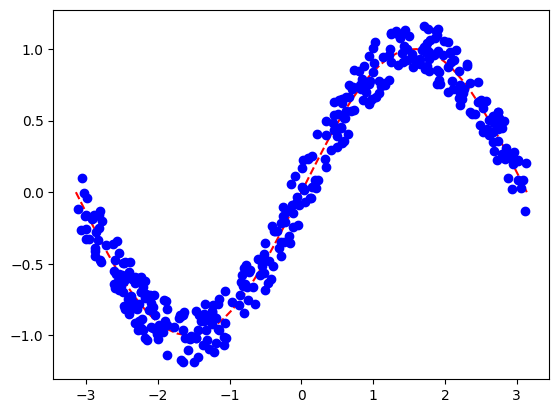

In [64]:
num_samples = 400
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

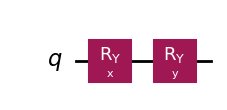

In [65]:
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm_2")
feature_map.ry(param_x,0)

param_y= Parameter("y")
ansatz =QuantumCircuit(1, name="vf_1")
ansatz.ry(param_y,0)

qc = QuantumCircuit(1)
qc.compose(feature_map, inplace =True)
qc.compose(ansatz, inplace = True)
qc.draw(output ="mpl")

Construct QNN

In [66]:
qnn_obm = EstimatorQNN(circuit=qc, input_params=[param_x], weight_params=[param_y])
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn_obm.num_weights) - 1)
model_obm_no_initial = TorchConnector(qnn_obm, initial_weights)


In [67]:
optimizer = LBFGS(model_obm_no_initial.parameters())

f_loss = MSELoss(reduction="sum")


model_obm_no_initial.train()

TorchConnector()

In [68]:
# Define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model_obm_no_initial(Tensor(X)), Tensor(y))  # Compute batch loss
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer
optimizer.step(closure)

410.9381103515625
84.54763793945312
160.12608337402344
5.519082069396973
5.454084396362305
5.453728199005127
5.453728199005127


tensor(410.9381, grad_fn=<MseLossBackward0>)

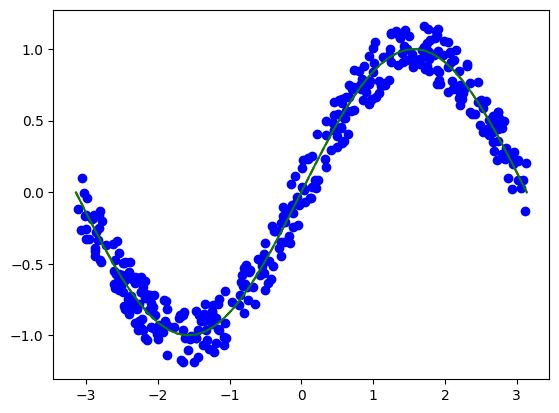

In [69]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

# Plot data
plt.plot(X, y, "bo")

# Plot fitted line
model_obm_no_initial.eval()
y_ = []
for x in np.linspace(lb, ub):
    output = model_obm_no_initial(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()

Layer types and mitigation is missing, will be added